# Bone fracture prediction and classification

#### Importing all required libraries

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import shutil

2023-12-31 03:27:20.480997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-31 03:27:20.481044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-31 03:27:20.482153: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-31 03:27:20.490311: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-31 03:27:21.372735: W tensorflow/compiler/tf2

In [3]:
Image_Size = 256
Batch_Size = 64
Channels = 3
Epochs = 100

In [4]:
# Add this at the beginning of your code
tf.random.set_seed(42)


#### Import Data

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./Bone_fracture_JPEG",
    shuffle = True,
    image_size = (Image_Size, Image_Size),
    batch_size = Batch_Size
)

Found 1735 files belonging to 12 classes.


2023-12-31 03:27:22.803316: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-31 03:27:22.838022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-31 03:27:22.838421: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Exploring data

In [6]:
classes = dataset.class_names
classes

['Avulsion fracture',
 'Comminuted fracture',
 'Compression-Crush fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Intra-articular fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

In [7]:
len(dataset)

28

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[ 2  0 10  0  5  1  9  8  8  8  4  3  7  7  8  6  1 10  5  4  4  3  4  6
  9  1  8  1  7  5  8  5  0  9  8  1  6  8  7 10 11  8 10  2 11  9  3  7
  9  1  9  6  3  1 10  2  1 10  3 11 11  9  2  3]


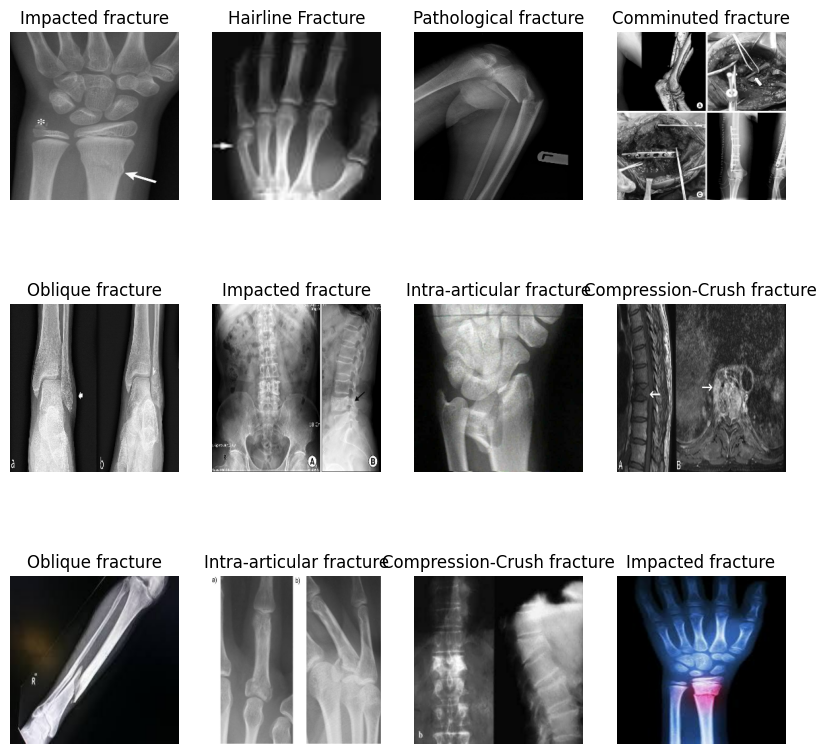

In [9]:
plt.figure(num=10, figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(min(12, len(image_batch))):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

#### Train Test Split

90% ==> training
10% ==> 5% validation, 5% test

In [10]:
def dataset_get_partitions_tf(ds, train_split=0.90, val_split=0.05, test_split=0.05, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = dataset_get_partitions_tf(dataset)

In [12]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

25
1
2


#### Shuffling data

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [14]:
# Calculate mean and std from the training dataset
normalization_layer = layers.experimental.preprocessing.Normalization()
normalization_layer.adapt(train_ds.map(lambda x, _: x))


In [15]:
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x, training=True), y))


#### Creating Layers and Model Building

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.3),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomContrast(0.2),
        layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
        
        #*More Augmentation added 
        layers.experimental.preprocessing.RandomHeight(0.2),
        layers.experimental.preprocessing.RandomWidth(0.2),
    ]
)

In [18]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


In [19]:
def swish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

# Some layers are removed to reduce the complexity of the model
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(16, (5, 5), input_shape=(256, 256, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(swish),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(32, (5, 5)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(swish),
        tf.keras.layers.MaxPooling2D(2, 2),

        # tf.keras.layers.Conv2D(64, (3, 3)),
        # tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Activation(swish),
        # tf.keras.layers.MaxPooling2D(2, 2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation(swish),
        tf.keras.layers.Dense(12, activation="softmax"),
    ]
)

In [20]:
# Use this while defining the model
# tf.keras.layers.BatchNormalization(),


In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 batch_normalization (Batch  (None, 252, 252, 16)      64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 252, 252, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      12832     
                                                                 
 batch_normalization_1 (Bat  (None, 122, 122, 32)     

In [22]:
# Implement learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    # After every 540 or 20 epochs steps, the learning rate will be reduced by 0.80
    decay_steps=27,
    decay_rate=0.98,
    staircase=False
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [23]:
model.compile(
    # use custom optimizer instead of 'adam'
    optimizer = optimizer,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [24]:
# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    # track the validation accuracy instead of the validation loss
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

In [25]:
class PrintLearningRate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr.numpy()))

# Add the callback to the list of callbacks in model.fit
callbacks = [early_stopping, PrintLearningRate()]

In [26]:
# Train the model with more epochs
history = model.fit(
    train_ds,
    epochs=100,  # Increase the number of epochs
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds,
    # Add the callbacks parameter to the fit function
    callbacks=callbacks
)

Epoch 1/100


2023-12-31 03:27:33.505889: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-31 03:27:33.629302: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-31 03:27:35.063379: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-31 03:27:35.364435: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-12-31 03:27:35.617671: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran o

 4/25 [===>..........................] - ETA: 4s - loss: 3.2466 - accuracy: 0.1094

2023-12-31 03:27:41.053955: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 506.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


25/25 [==============================] - ETA: 0s - loss: 2.7118 - accuracy: 0.1653
Learning rate for epoch 1 is 0.0009822023566812277
25/25 [==============================] - 17s 358ms/step - loss: 2.7118 - accuracy: 0.1653 - val_loss: 16.0018 - val_accuracy: 0.1562
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 2.0653 - accuracy: 0.3266
Learning rate for epoch 2 is 0.0009639998897910118
25/25 [==============================] - 6s 226ms/step - loss: 2.0653 - accuracy: 0.3266 - val_loss: 3.8746 - val_accuracy: 0.1875
Epoch 3/100
15/25 [=================>............] - ETA: 2s - loss: 1.6726 - accuracy: 0.4906

2023-12-31 03:27:57.841198: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 506.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


25/25 [==============================] - ETA: 0s - loss: 1.6622 - accuracy: 0.4887
Learning rate for epoch 3 is 0.0009461347362957895
25/25 [==============================] - 6s 226ms/step - loss: 1.6622 - accuracy: 0.4887 - val_loss: 1.8859 - val_accuracy: 0.4375
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 1.1599 - accuracy: 0.6656
Learning rate for epoch 4 is 0.000928600667975843
25/25 [==============================] - 6s 226ms/step - loss: 1.1599 - accuracy: 0.6656 - val_loss: 1.2936 - val_accuracy: 0.6094
Epoch 5/100
25/25 [==============================] - ETA: 0s - loss: 0.7616 - accuracy: 0.7971
Learning rate for epoch 5 is 0.0009113915148191154
25/25 [==============================] - 6s 226ms/step - loss: 0.7616 - accuracy: 0.7971 - val_loss: 1.0771 - val_accuracy: 0.7344
Epoch 6/100
25/25 [==============================] - ETA: 0s - loss: 0.5198 - accuracy: 0.8594
Learning rate for epoch 6 is 0.0008945013978518546
25/25 [=============================

In [27]:
scores = model.evaluate(test_ds)


2/2 [==============================] - 2s 92ms/step - loss: 0.6490 - accuracy: 0.8281


In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

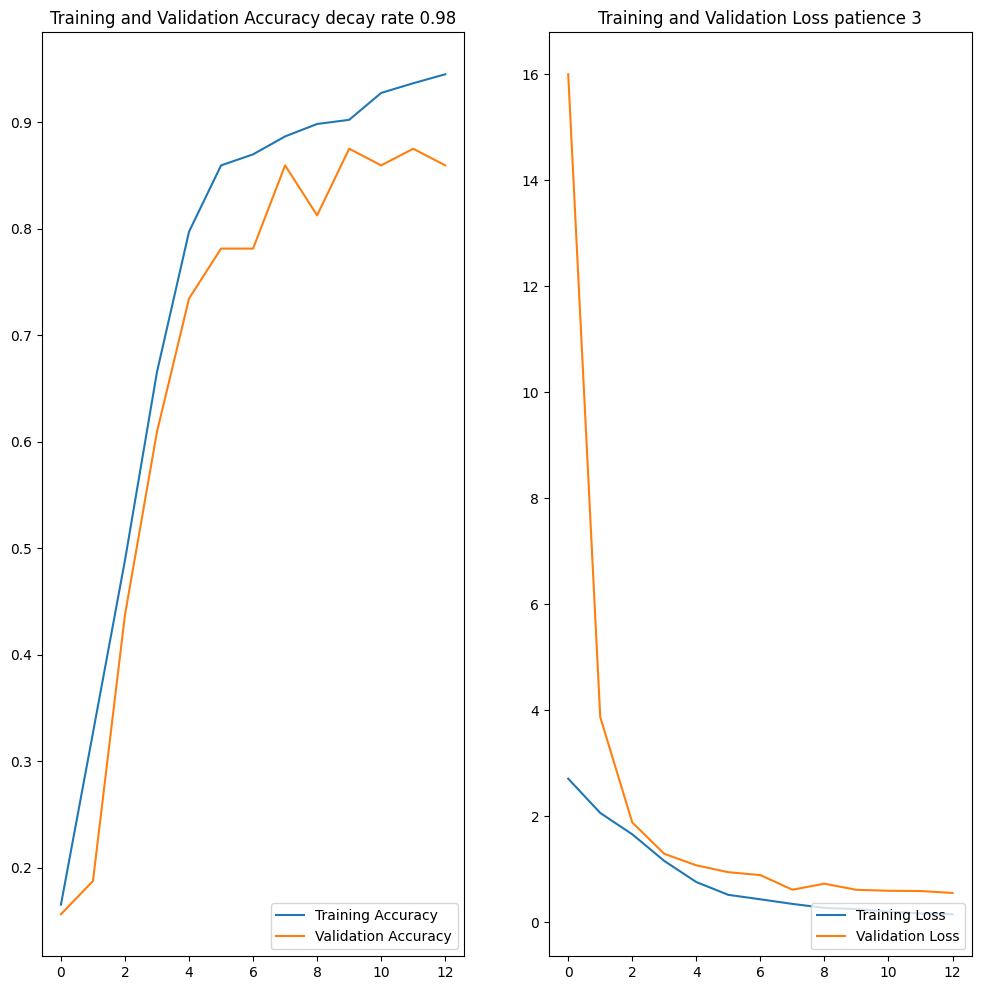

In [29]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.plot(range(len(acc)), acc[:len(acc)], label = 'Training Accuracy')
plt.plot(range(len(val_acc)), val_acc[:len(val_acc)], label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title(f'Training and Validation Accuracy decay rate {lr_schedule.decay_rate}')
plt.subplot(1,2,2)
plt.plot(range(len(loss)), loss[:len(loss)], label = 'Training Loss')
plt.plot(range(len(val_loss)), val_loss[:len(val_loss)], label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title(f'Training and Validation Loss patience {early_stopping.patience}')
plt.show()

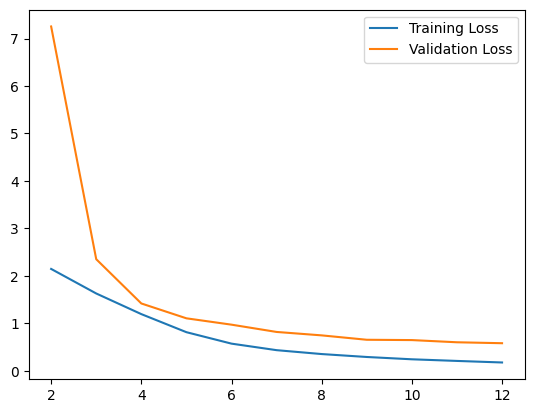

In [30]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df['loss_smooth'] = history_df['loss'].rolling(3).mean()
history_df['val_loss_smooth'] = history_df['val_loss'].rolling(3).mean()

plt.plot(history_df['loss_smooth'], label='Training Loss')
plt.plot(history_df['val_loss_smooth'], label='Validation Loss')
plt.legend()
plt.show()


2/2 [==============================] - 1s 22ms/step


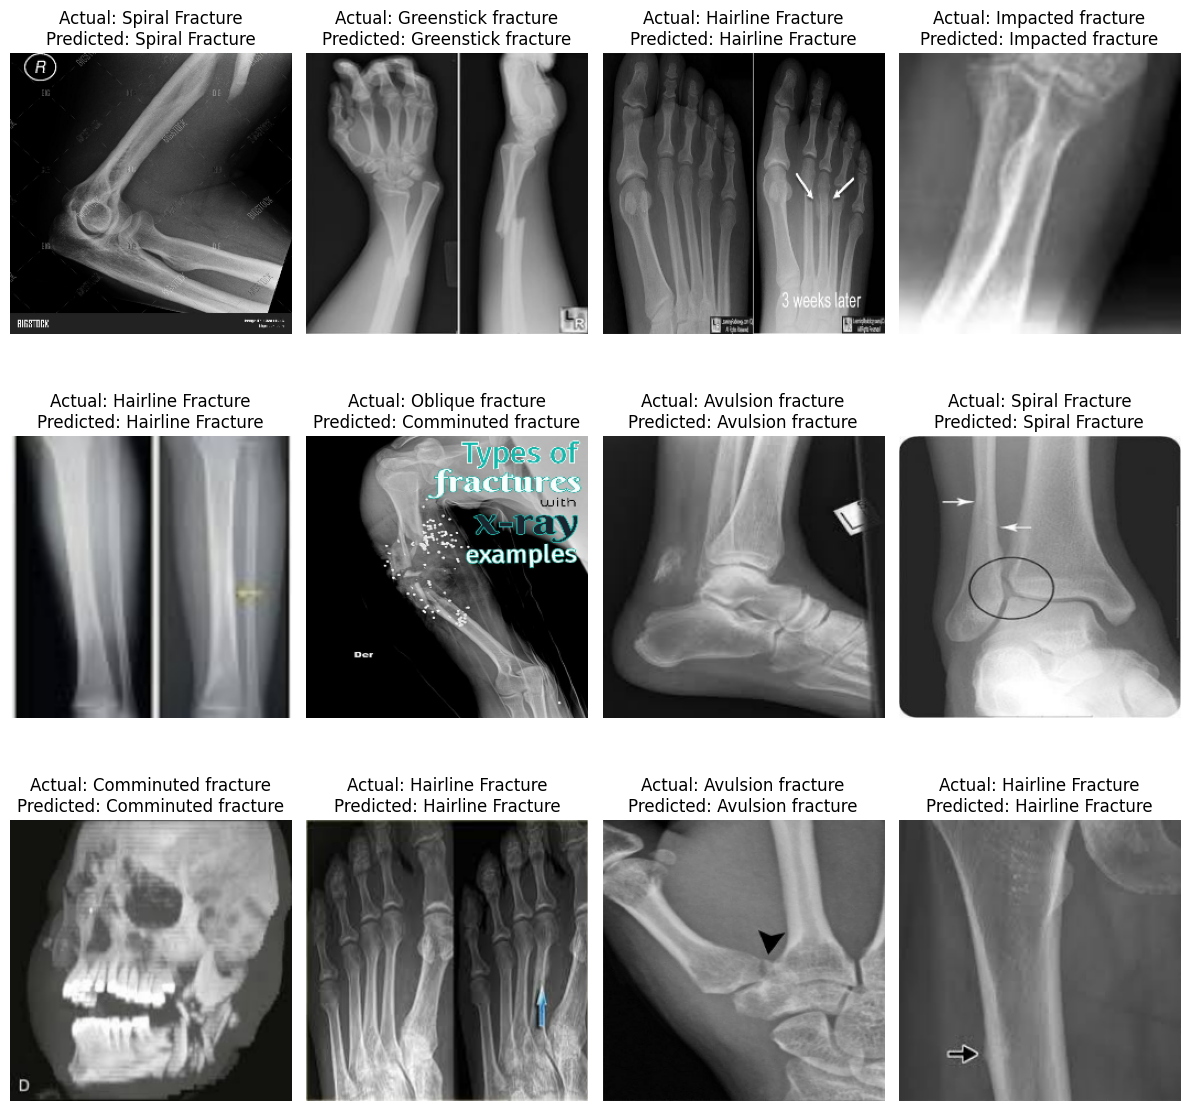

In [31]:
# Get some random samples from the test dataset
sample_images = []
sample_labels = []
for images, labels in test_ds.take(1):
    sample_images = images.numpy()
    sample_labels = labels.numpy()

# Make predictions on the random samples
predictions = model.predict(sample_images)

# Visualize random samples with actual and predicted labels
num_samples = len(sample_images)
num_rows = 3
num_cols = 4
plt.figure(figsize=(12, 12))
for i in range(min(num_samples, num_rows * num_cols)):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    actual_label = classes[sample_labels[i]]
    predicted_label = classes[np.argmax(predictions[i])]
    title = f"Actual: {actual_label}\nPredicted: {predicted_label}"
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [32]:
'''
Tweaks to improve the model
1. Increase the number of epochs
2. Decrease the number of layers
3. Increase augmentation
4. Use Batch Normalization
5. Use Learning Rate Scheduling with Staircase
6. Use Early Stopping
7. Use Swish Activation Function (relu not working well)
8. Track val_accuracy instead of val_loss

'''

'\nTweaks to improve the model\n1. Increase the number of epochs\n2. Decrease the number of layers\n3. Increase augmentation\n4. Use Batch Normalization\n5. Use Learning Rate Scheduling with Staircase\n6. Use Early Stopping\n7. Use Swish Activation Function (relu not working well)\n8. Track val_accuracy instead of val_loss\n\n'